In [171]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [172]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [173]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [174]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

In [175]:
airi_dat

<xarray.Dataset>
Dimensions:  (time: 1752)
Coordinates:
  * time     (time) datetime64[ns] 1871-02-01 1871-03-01 ... 2017-01-01
Data variables:
    precip   (time) float32 ...
Attributes:
    title:        
    description:  All-India Rainfall
    scripturl01:  https://climexp.knmi.nl/getindices.cgi?STATION=All-India_Ra...
    comment:      
    institution:  KNMI Climate Explorer
    scripturl02:  https://climexp.knmi.nl/dat2nc.cgi?id=$id&station=All-India...
    history:       2020-04-02  2:43:20 bin/dat2nc data/pALLIN.dat p All-India...
    Conventions:  CF-1.0

In [176]:
precip = airi_dat['precip']

In [177]:
#Load MSE data
dataset_url = "MSE_20thcentury.nc"
mse_dat1 = xr.open_dataset('/global/scratch/medhap02/MSE_20thcentury.nc')
mse_dat = mse_dat1.rename({'LON':'lon', 'LAT':'lat','TIME':'time'})
mse = mse_dat['MSE']
print(mse_dat)

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 181, lon: 360, time: 2160)
Coordinates:
  * lon        (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * lat        (lat) float64 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * time       (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Dimensions without coordinates: bnds
Data variables:
    TIME_bnds  (time, bnds) datetime64[ns] ...
    MSE        (time, lat, lon) float64 ...
    DMSEDT     (time, lat, lon) float64 ...
Attributes:
    history:      PyFerret V7.43 (optimized) 14-May-20
    Conventions:  CF-1.6


In [178]:
mse[1950,:,:]

<xarray.DataArray 'MSE' (lat: 181, lon: 360)>
array([[226840.197219, 226840.197219, 226840.197219, ..., 226840.197219,
        226840.197219, 226840.197219],
       [226843.584283, 226823.131608, 226809.02599 , ..., 226897.710251,
        226880.505183, 226861.215806],
       [226515.43398 , 226459.668853, 226407.824075, ..., 226725.489409,
        226656.641126, 226584.999081],
       ...,
       [284155.095137, 284155.923731, 284155.640129, ..., 284148.737619,
        284151.610734, 284153.2147  ],
       [284101.037336, 284101.122701, 284101.141537, ..., 284099.908306,
        284100.971691, 284101.521576],
       [284026.176127, 284026.176127, 284026.176127, ..., 284026.176127,
        284026.176127, 284026.176127]])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
    time     datetime64[ns] 1998-07-01
Attributes:
    long_name:  Moist Static Energy
    uni

In [179]:
#Slice MSE data to the same duration as precip and calculate monthly anomalies
mse_subset = mse.sel(time=slice('1871-01-30','2017-01-01'))
mse_clim = mse_subset.groupby('time.month').mean('time')
mse_anomfull = mse_subset.groupby("time.month")-mse_clim
mse_anomfull

<xarray.DataArray 'MSE' (time: 1739, lat: 181, lon: 360)>
array([[[ -437.976186,  -437.976186, ...,  -437.976186,  -437.976186],
        [ -357.903304,  -357.881208, ...,  -348.426553,  -351.846723],
        ...,
        [-4136.464814, -4142.140899, ..., -4125.058225, -4129.258011],
        [-3946.385781, -3946.385781, ..., -3946.385781, -3946.385781]],

       [[ -685.706864,  -685.706864, ...,  -685.706864,  -685.706864],
        [ -523.262003,  -522.176401, ...,  -528.206152,  -525.088336],
        ...,
        [-2774.219152, -2771.776149, ..., -2769.221152, -2770.293549],
        [-2662.830975, -2662.830975, ..., -2662.830975, -2662.830975]],

       ...,

       [[ 2257.7285  ,  2257.7285  , ...,  2257.7285  ,  2257.7285  ],
        [ 2691.46434 ,  2695.995047, ...,  2682.928563,  2688.836707],
        ...,
        [ 3071.988646,  3092.121979, ...,  3027.33813 ,  3049.99822 ],
        [ 3156.791382,  3156.791382, ...,  3156.791382,  3156.791382]],

       [[  864.856915,   864.856

In [180]:
mse_anom = mse_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))

In [199]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

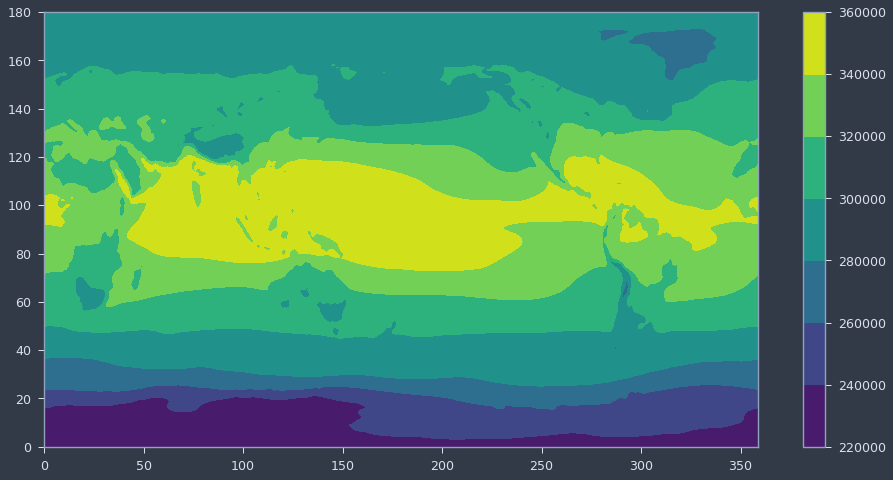

In [181]:
#Test plot of mse_clim
plt.contourf(mse_clim.sel(month=6))
plt.colorbar()

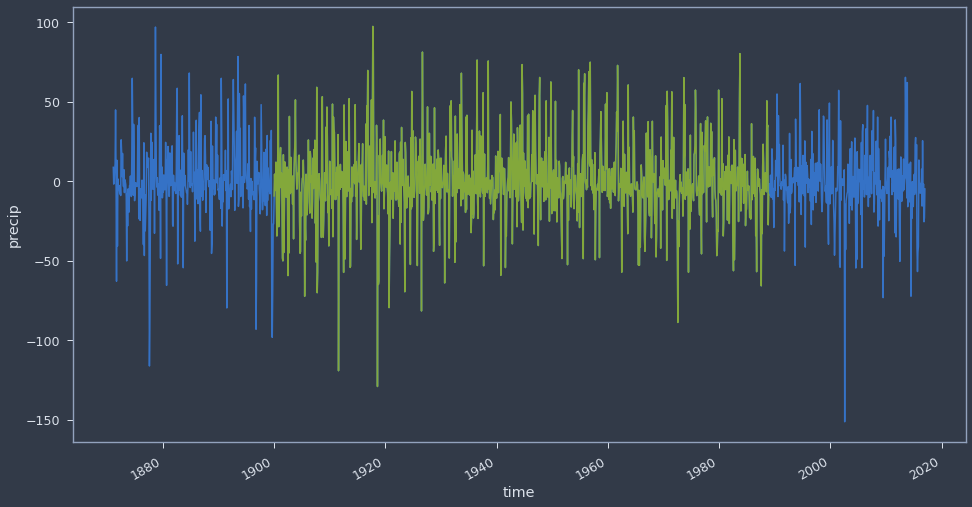

In [182]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim
precip_anom = precip_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))
precip_anomfull.plot()
precip_anom.plot()

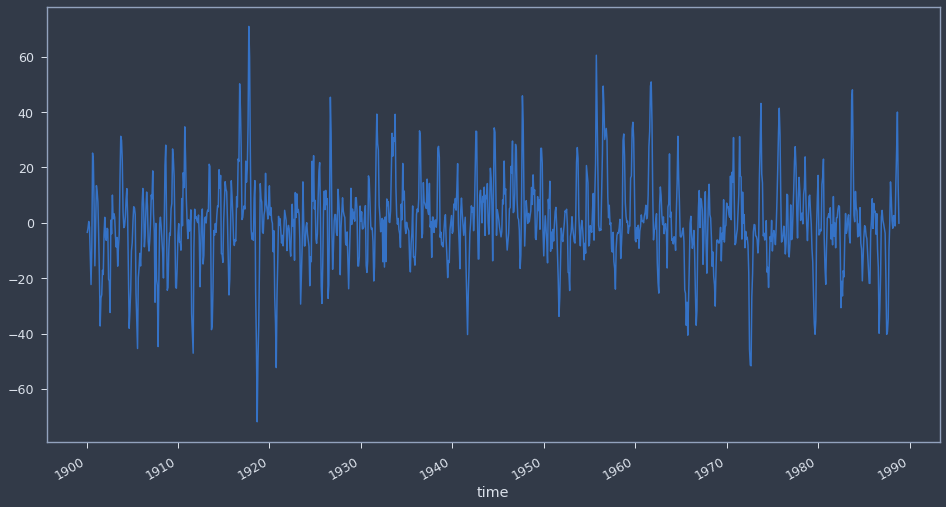

In [183]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [184]:
#Seasonal means of mseA
msea_seasonal = mse_anom.rolling(time=3,center=True).mean()
msea_seasonal

<xarray.DataArray (time: 1068, lat: 181, lon: 360)>
array([[[         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan],
        ...,
        [         nan,          nan, ...,          nan,          nan],
        [         nan,          nan, ...,          nan,          nan]],

       [[  -29.739481,   -29.739481, ...,   -29.739481,   -29.739481],
        [  -57.347446,   -56.362034, ...,   -57.461762,   -57.631168],
        ...,
        [  196.47479 ,   192.495343, ...,   203.931508,   199.956729],
        [  269.885766,   269.885766, ...,   269.885766,   269.885766]],

       ...,

       [[  398.872028,   398.872028, ...,   398.872028,   398.872028],
        [  630.47767 ,   635.564746, ...,   620.406891,   625.529811],
        ...,
        [-2405.439816, -2408.114242, ..., -2403.881557, -2404.473116],
        [-2259.811335, -2259.811335, ..., -2259.811335, -2259.811335]],

       [[         nan,          nan, .

#Test plot of seasonal SST anomalies in DJF 1997-8
plt.contourf(ssta_seasonal.sel(time='1998-01-01'))
plt.colorbar()

In [185]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [186]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = msea_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
mse_r = correlation(x, y, dims='time')
#y = msea_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'

Text(0.5, 1.0, 'Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)')

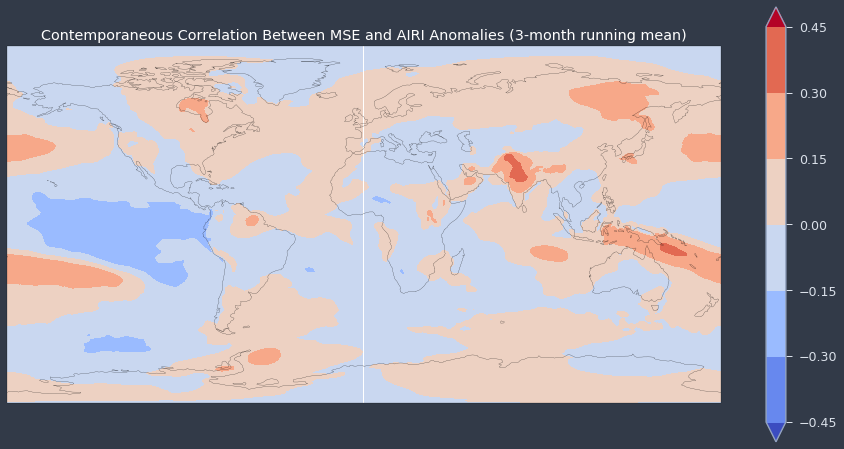

In [203]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (3-month running mean)', color = 'white')

In [188]:
#Try the same with only JJA:
julys=np.arange(6,1068,12) #1752 instead of 1068
msea_jja = msea_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
mse_jja_r = correlation(msea_jja,precipa_jja,dims='time')

Text(0.5, 1.0, 'Contemporaneous Correlation Between MSE and AIRI Anomalies (JJA Mean)')

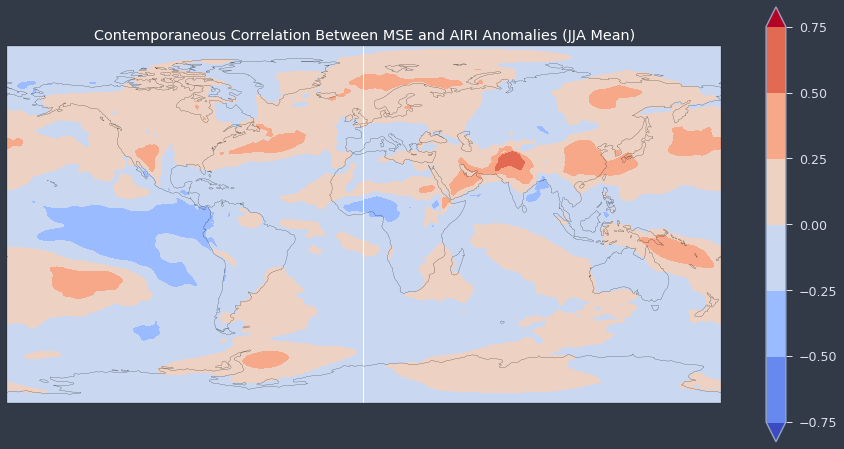

In [204]:
#Plot JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_jja_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_jja_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Contemporaneous Correlation Between MSE and AIRI Anomalies (JJA Mean)', color = 'white')

In [190]:
#Try this with a lag of 3 months
msea_seasonal_3shift = msea_seasonal.shift(time=-3)
msea_mam = msea_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted MSEA (by 3 months)')

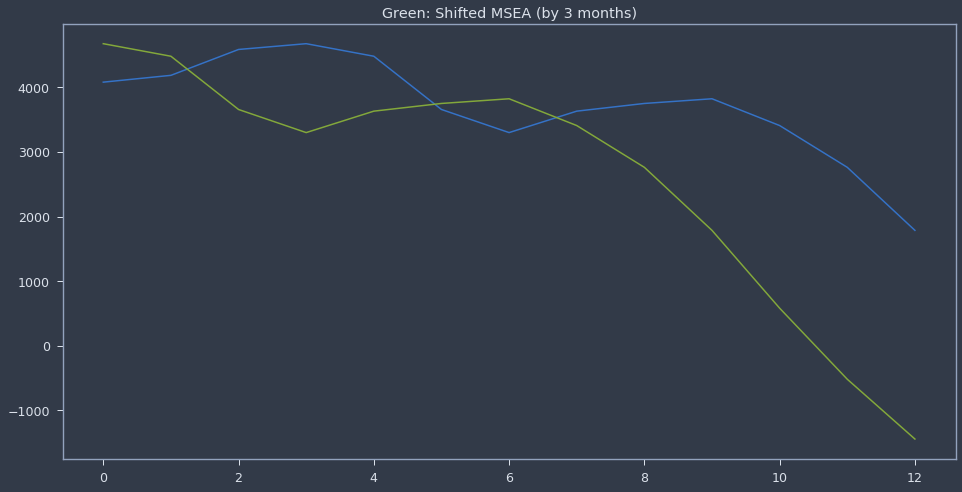

In [191]:
plt.plot(msea_seasonal.sel(lon=270,lat=0,time=slice('1987-01-01','1988-01-01')))
plt.plot(msea_seasonal_3shift.sel(lon=270,lat=0,time=slice('1987-01-01','1988-01-01')))
plt.title('Green: Shifted MSEA (by 3 months)')

In [192]:
#Run correlation
mse_mam_r = correlation(msea_mam,precipa_jja,dims='time')

Text(0.5, 1.0, 'Correlation Between MAM MSE and JJA AIRI Anomalies')

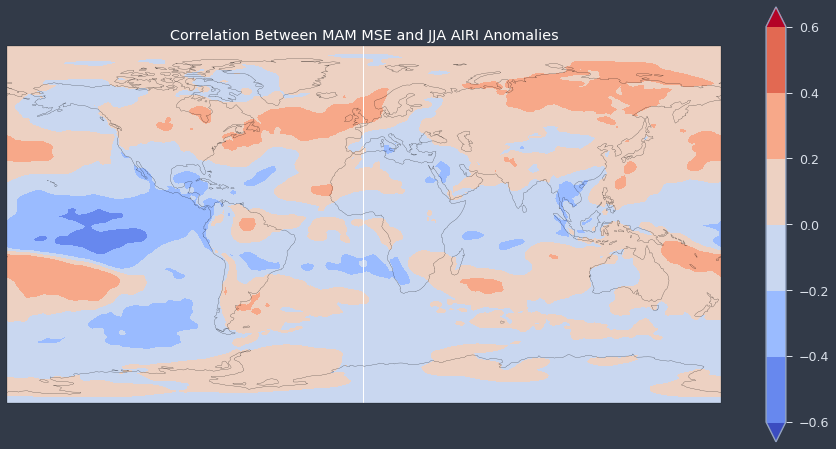

In [205]:
#Plot MAM/JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_mam_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_mam_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Correlation Between MAM MSE and JJA AIRI Anomalies', color = 'white')

In [206]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
msea_2shift_dt = mse_anom-mse_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1068,12)
precipa_jjas = precipa_4seasonal[septembers]
msea_2shift_dt_sep = msea_2shift_dt.shift(time=4)[septembers,:,:]

In [207]:
mse_may_mar_r = correlation(msea_2shift_dt_sep,precipa_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between May-March MSEA and JJAS AIRI Anomalies')

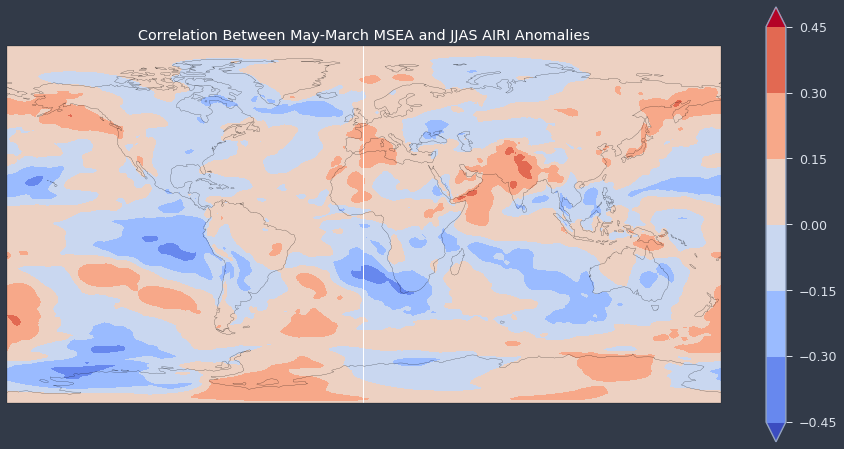

In [208]:
#Plot correlation
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
mse_may_mar_r.plot.contourf(cmap='coolwarm',extend='both')
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(mse_may_mar_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
plt.title('Correlation Between May-March MSEA and JJAS AIRI Anomalies', color = 'white')

In [197]:
# Copyright (c) 2020 Medha Palavalli.